Epoch 0, Accuracy: 2.50%
Epoch 10, Accuracy: 2.73%
Epoch 20, Accuracy: 3.40%
Epoch 30, Accuracy: 4.17%
Epoch 40, Accuracy: 4.79%
Epoch 50, Accuracy: 5.71%
Epoch 60, Accuracy: 7.58%
Epoch 70, Accuracy: 10.15%
Epoch 80, Accuracy: 12.56%
Epoch 90, Accuracy: 14.86%
Epoch 100, Accuracy: 17.21%
Epoch 110, Accuracy: 19.58%
Epoch 120, Accuracy: 21.95%
Epoch 130, Accuracy: 24.55%
Epoch 140, Accuracy: 27.61%
Epoch 150, Accuracy: 30.72%
Epoch 160, Accuracy: 34.04%
Epoch 170, Accuracy: 37.18%
Epoch 180, Accuracy: 40.05%
Epoch 190, Accuracy: 42.89%
Epoch 200, Accuracy: 45.44%
Epoch 210, Accuracy: 47.82%
Epoch 220, Accuracy: 49.95%
Epoch 230, Accuracy: 51.84%
Epoch 240, Accuracy: 53.49%
Epoch 250, Accuracy: 54.93%
Epoch 260, Accuracy: 56.21%
Epoch 270, Accuracy: 57.37%
Epoch 280, Accuracy: 58.34%
Epoch 290, Accuracy: 59.22%
Epoch 300, Accuracy: 60.09%
Epoch 310, Accuracy: 60.85%
Epoch 320, Accuracy: 61.62%
Epoch 330, Accuracy: 62.27%
Epoch 340, Accuracy: 62.82%
Epoch 350, Accuracy: 63.43%
Epoch 360,

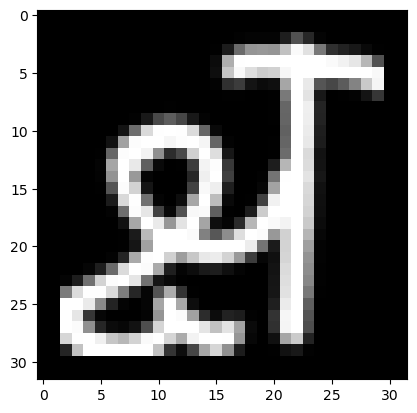

Predicted value:
४
Actual value:
४


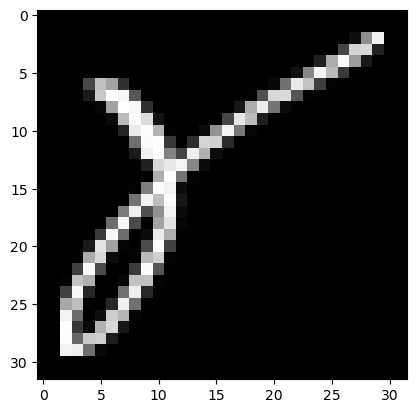

Predicted value:
०
Actual value:
०


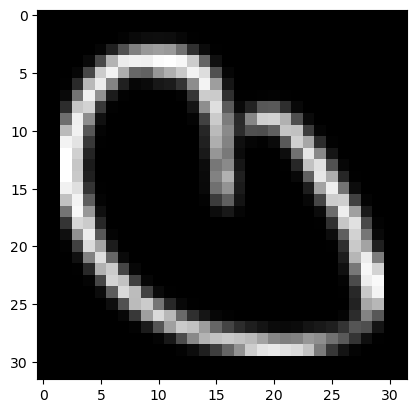

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataloader import DHCDataset
from PIL import Image

from torch.optim.lr_scheduler import CyclicLR

# Load data using the custom DHCDataset
dataManager = DHCDataset('./dataset/dataset.npz')

# Extract the training and test data
train = dataManager.image_train
train_label = dataManager.label_train
test = dataManager.image_test
test_label = dataManager.label_test

# Decrement the labels by 1 to start from 0
train_label -= 1
test_label -= 1

# Normalize and reshape the data
train = train.reshape(78200, 1024).T / 255.
test = test.reshape(13800, 1024).T / 255.

# Convert data to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train = torch.tensor(train, dtype=torch.float32).to(device)
train_label = torch.tensor(train_label, dtype=torch.long).to(device)
test = torch.tensor(test, dtype=torch.float32).to(device)
test_label = torch.tensor(test_label, dtype=torch.long).to(device)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(1024, 46)
        self.fc2 = nn.Linear(46, 46)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=2000, mode='triangular')

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    return (preds == labels).sum().item() / labels.size(0)

# Training loop
for epoch in range(50000):
    optimizer.zero_grad()
    outputs = model(train.T)
    loss = criterion(outputs, train_label)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update the learning rate
    
    if epoch % 10 == 0:
        acc = accuracy(outputs, train_label)
        print(f'Epoch {epoch}, Accuracy: {acc * 100:.2f}%')

# Testing function
def test_result():
    with torch.no_grad():
        outputs = model(test.T)
        acc = accuracy(outputs, test_label)
        print(f'Test Accuracy: {acc * 100:.2f}%')

test_result()

# Function to display prediction and actual value
def inNepali(val):
    words = ['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 
             'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
    print(words[int(val)])

def trial(index):
    current_image = train[:, index].unsqueeze(1).T
    with torch.no_grad():
        output = model(current_image)
    prediction = torch.argmax(output, 1).item()
    print("Predicted value:")
    inNepali(prediction)
    print("Actual value:")
    inNepali(train_label[index].item())

    # Draw the image
    image = train[:, index].cpu().numpy().reshape((32, 32)) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()

trial(2434)
trial(17834)
trial(29991)